In [1]:
import matplotlib.pyplot as plt
from datetime import datetime, time
from dateutil.relativedelta import relativedelta
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import ta
import mplfinance as mpf
from itertools import product
import numpy as np

from tqdm import tqdm

In [2]:
from src.DataUpdateModule import DataUpdateModule
from src.Strategy import Strategy
from src.DayTrade import DayTrade
DUM = DataUpdateModule(options_interval_minutes = 5)
strategy = Strategy()

In [4]:
AUM = 6.5 * 1e6


models_AUM = [AUM] * len(strategy.get_models())
all_all_trades = list()
for trade_day in [datetime(2022,1,7), datetime(2022,1,14), datetime(2022,1,21), datetime(2022,1,28)]:
    df_stock, df_options = DUM.read_data(trade_day)
    strategy.compute_tech_indicators(df_stock)
    all_trades = list()
    for model_num in tqdm(range(len(strategy.get_models()))):
        DT = DayTrade(strategy, model_num = model_num, AUM = models_AUM[model_num], df_options = df_options, commission_dollars = 0.15, max_risk = 0.025, interval = 5)
        trades = DT.trade()
        models_AUM[model_num] += trades.loc[:, "pnl"].sum() if len(trades) > 0 else 0
        all_trades.append(trades)
    param_pnl = pd.DataFrame([strategy.get_models(x) | {"pnl" : all_trades[x]["pnl"].sum(), "model_num" : x} for x in range(len(all_trades))]).assign(day = trade_day)
    all_all_trades.append(param_pnl)
all_all_trades = pd.concat(all_all_trades)

100%|██████████| 512/512 [00:49<00:00, 10.40it/s]


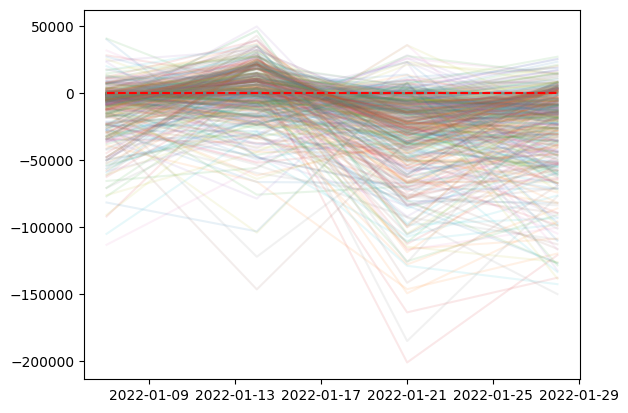

In [29]:
for model_num in all_all_trades.loc[:, "model_num"].unique():
    df_plot = all_all_trades[all_all_trades.loc[:, "model_num"] == model_num]
    plt.plot(df_plot.loc[:, "day"], df_plot.loc[:, "pnl"], alpha = 0.1)
plt.hlines(y = 0, xmin = all_all_trades.loc[:, "day"].min(), xmax = all_all_trades.loc[:, "day"].max(), color = "red", linestyle = "--")

In [ ]:
ratio = dict()

for model_num in all_all_trades.loc[:, "model_num"].unique():
    df_plot = all_all_trades[all_all_trades.loc[:, "model_num"] == model_num]
    ratio[model_num] = df_plot.loc[:, "pnl"].mean() / df_plot.loc[:, "pnl"].std()

pd.Series(ratio).sort_values(ascending = False)

300   0.61103377
500   0.54062683
370   0.52301106
120   0.50000000
56    0.50000000
         ...    
376          NaN
408          NaN
440          NaN
472          NaN
504          NaN
Length: 512, dtype: float64

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

In [16]:
X = all_all_trades.drop(columns = ["pnl", "model_num", "day"])
y = all_all_trades.loc[:, "pnl"]

RFR = RandomForestRegressor(n_estimators = 100, random_state = 408).fit(X, y)


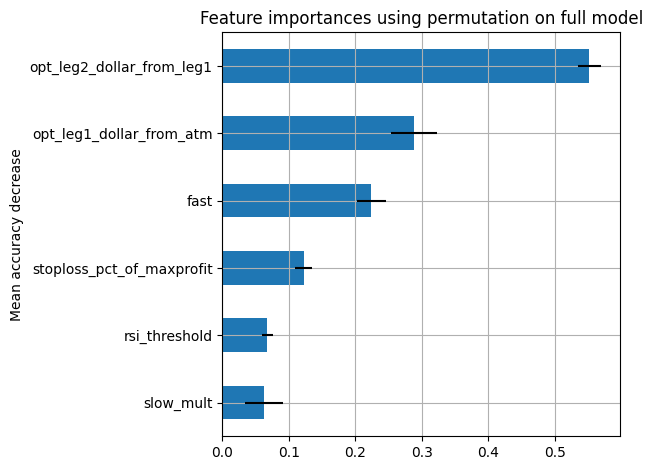

In [17]:
pi = permutation_importance(RFR, X, y, n_repeats=10, random_state=42, n_jobs=-1)
forest_importances = pd.Series(pi.importances_mean, index=X.columns).sort_values()

fig, ax = plt.subplots()
forest_importances.plot.barh(xerr=pi.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
ax.grid()
fig.tight_layout()
plt.show()

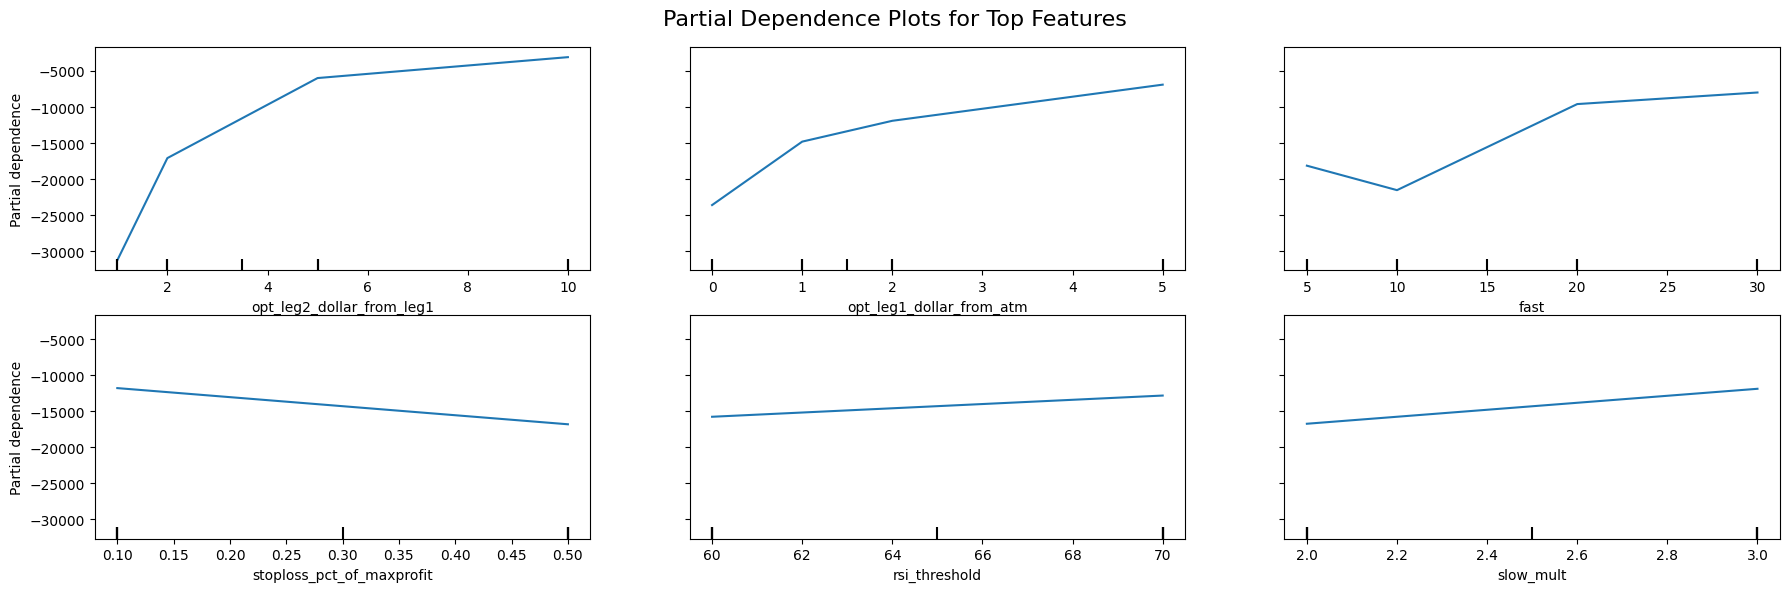

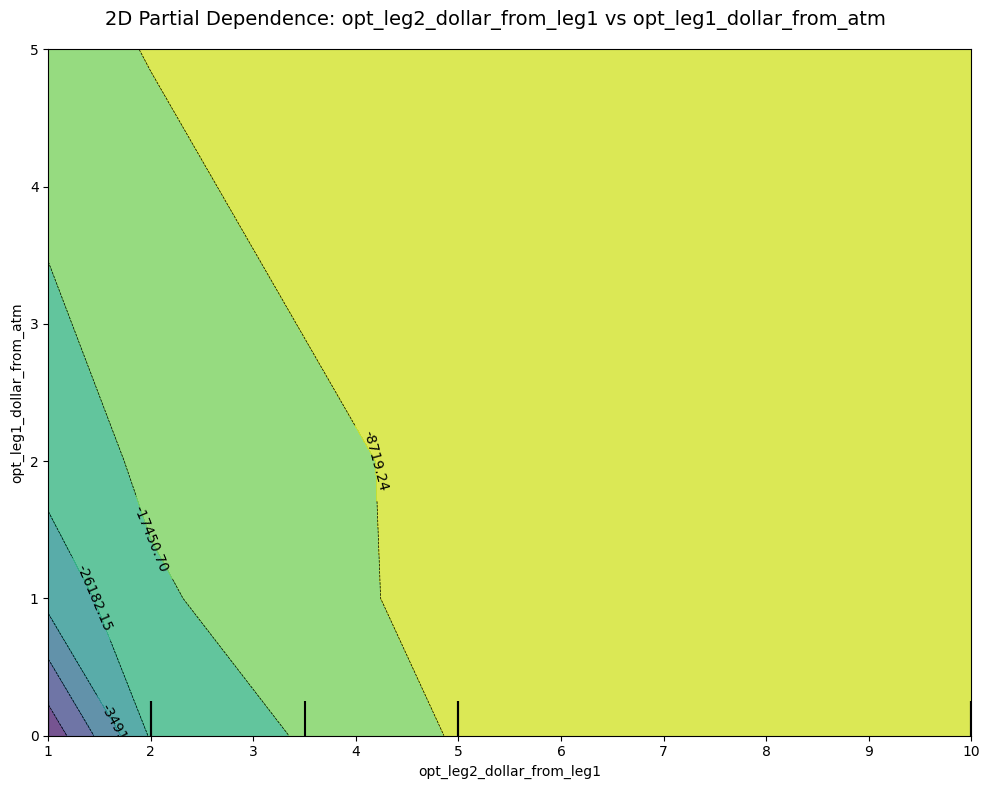

In [18]:
from sklearn.inspection import PartialDependenceDisplay

forest_importances = pd.Series(pi.importances_mean, index=X.columns).sort_values(ascending=False)

# Select top N features (e.g., top 4-6 features)
top_n = 6
top_features = forest_importances.head(top_n).index.tolist()

# Generate partial dependence plots for top features
fig, ax = plt.subplots(figsize=(18, 6))
PartialDependenceDisplay.from_estimator(
    RFR,
    X,
    features=top_features,
    kind="average",  # or "individual" for ICE plots, or "both"
    grid_resolution=50,
    n_jobs=-1,
    ax=ax,
)
plt.suptitle("Partial Dependence Plots for Top Features", fontsize=16)
plt.tight_layout()
plt.show()

# Alternative: Create 2D partial dependence plot for feature interactions
# Select top 2 features for interaction plot
if len(top_features) >= 2:
    fig, ax = plt.subplots(figsize=(10, 8))
    PartialDependenceDisplay.from_estimator(
        RFR,
        X,
        features=[(top_features[0], top_features[1])],  # Feature pair
        kind="average",
        grid_resolution=20,
        n_jobs=-1,
        ax=ax
    )
    plt.suptitle(f"2D Partial Dependence: {top_features[0]} vs {top_features[1]}", fontsize=14)
    plt.tight_layout()
    plt.show()

In [ ]:
param_pnl.sort_values("pnl", ascending = False)

,fast,slow_mult,rsi_threshold,opt_leg1_dollar_from_atm,opt_leg2_dollar_from_leg1,stoploss_pct_of_maxprofit,pnl
93,5,5,70,0,2,0.50000000,47509.80000000
289,20,5,60,0,1,0.50000000,32586.80000000
291,20,5,60,0,2,0.50000000,32489.80000000
91,5,5,70,0,1,0.50000000,31034.80000000
254,20,3,60,0,2,0.10000000,22204.60000000
...,...,...,...,...,...,...,...
198,10,5,70,0,1,0.10000000,-64937.40000000
18,5,2,70,0,1,0.10000000,-74354.40000000
108,10,2,60,0,1,0.10000000,-75426.40000000
109,10,2,60,0,1,0.50000000,-85950.80000000
